# Preliminary study on VLLS and VLLD yields

I am considering the 2018 scenario with luminosity 59.8 fb$^{-1}$. I am investigating the singlet as well as the doublet models of VLL in purely electron like, and purely muon like scenarios. The following are the final states that I am interested in.
- 4L (inclusive)
- Exactly 3L
- Exactly 2L (OS and SS)
- Exactly 1L and XJ (X = 2+, 1, 0)
  
These final states are orthogonal to each other and the filling order does not matter.

### Object and event selections
I am picking medium ID electrons and muon as L with pT>10 and fabs(eta)<2.4 <br>
The Jets have pT>30 and abs(eta)<2.3 with standard selections.<br>
These reco objects are dR-cleaned by 0.5 from the other loose objects.
Here is a link to the details of object selections - https://github.com/phazarik/VLLSearch-Run3/blob/main/Setup/ProduceRecoCollection.h <br>
Here is a link to the details of event selections - https://github.com/phazarik/VLLSearch-Run3/blob/prachu_2LSS/Setup/EventSelection.h

### Trigger and cuts
The event should have at least one muon with pT>26 GeV, or one electron with pT>35 GeV. Right now I am not considering whether this lepton should be a part of the final state object or not (for channels containing more than one leptons). **There are no additional cuts right now.** Later, more cuts will be put on the individual channels to purify signals, which will bring down the acceptance and yield.

### Corrections for the doublet models
The VLLD models contain some <span style="color:red;">invalid</span> decay modes which are mentioned below.<br>
<div style="text-align:center;">
    $L\rightarrow W\nu_\tau$<br>
    $N\rightarrow H\nu_\tau, Z\nu_\tau$
</div>
We calculate acceptance by doing <code>nevt_in_channel/nevt_in_file</code>. However, in this case, the denomnator itself is reducing because of the event flag I used to get rid of these invalid decays. These is no such modification to the singlet models.

In [1]:
import ROOT
import os, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
print('modules loaded.')

Welcome to JupyROOT 6.26/10
modules loaded.


In [2]:
jobname = 'hist_2018UL_Jul24_signal'

#signal_file = 'signal_database.json'
lumidata = '../../../InputJsons/lumidata_2018.json'
with open(lumidata, 'r') as file: json_data = json.load(file)
print('Signal database loaded!')

datestamp = datetime.today().strftime('%Y-%m-%d')
plotdir = 'plots/'+datestamp
os.system(f'mkdir -p {plotdir}')
print('Plot directory ready!')

thin_line = {
    'marker':'o',
    'linestyle':'--',
    'markersize':3,
    'linewidth':1
}
thick_line = {
    'marker':'o',
    'linestyle':'-',
    'markersize':4,
    'linewidth':2
}

masses = [100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 600, 750, 800, 1000]

def accp(num, den):
    if den==0 : return 0
    else : return (num/den)*100

def lumiscale(lumi):
    datalumi = 59800
    scale = datalumi/lumi
    return scale

print('settings loaded.')

Signal database loaded!
Plot directory ready!
settings loaded.


In [3]:
json_data

{'DYJetsToLL': {'M10to50': 5925.522, 'M50': 30321.155},
 'HTbinnedWJets': {'70to100': 52100.91,
  '100to200': 41127.174,
  '200to400': 172265.183,
  '400to600': 163821.083,
  '600to800': 708793.021,
  '800to1200': 1481985.193,
  '1200to2500': 5602003.457,
  '2500toInf': 79396214.989},
 'QCD_MuEnriched': {'20to30': 23.893,
  '30to50': 42.906,
  '50to80': 105.88,
  '80to120': 508.715,
  '120to170': 1802.854,
  '170to300': 10265.815,
  '300to470': 95249.242,
  '470to600': 656872.156,
  '600to800': 2060827.812,
  '800to1000': 11337379.457},
 'QCD_EMEnriched': {'15to20': 5.96666541,
  '20to30': 2.92664338,
  '30to50': 1.33001225,
  '50to80': 5.28031791,
  '80to120': 25.76427755,
  '120to170': 145.33569605,
  '170to300': 223.50433213,
  '300toInf': 2007.24094203},
 'SingleTop': {'s-channel_LeptonDecays': 5456748.098,
  't-channel_AntiTop_InclusiveDecays': 1407728.544,
  't-channel_Top_InclusiveDecays': 1572627.866,
  'tW_AntiTop_InclusiceDecays': 238357.428,
  'tW_Top_InclusiveDecays': 24517

#### Preparing the function to fillup a dictionary with acceptance and yields across the mass-points

In [4]:
def check_yields(model):
    plotdict = {
        '1L0J':{'color':'yellow',},
        '1L1J':{'color':'gold'},
        '1L2J':{'color':'orange'},
        '2LOS':{'color':'blue'},
        '2LSS':{'color':'darkblue'},
        '3L'  :{'color':'green'},
        '4L'  :{'color':'red'}
    }

    print(f'Yield (acceptance %) for {model} :')
    print(f'mass\tnRAW\tn1L0J\t\tn1L1J\t\tn1L2J\t\tn2LOS\t\tn2LSS\t\tn3L\t\tn4L')
    
    for mass in masses:
        for key, val in json_data.items():
            if key == model:
                
                filename = f'input_hists/{jobname}/hst_{model}_M{str(mass)}.root'
                file_exists = os.path.exists(filename)
                
                if file_exists:
                    tfile = ROOT.TFile(filename)
                    hist = tfile.Get(f'finalstates_incldecay')
                    nall = hist.GetBinContent(1)
                    
                    print(f'\n{mass}\t{int(nall)}', end='\t')
                    
                    # For each final state:
                    for index, channel in enumerate(plotdict.keys()):
                        plotdict[channel][mass] = {}
                        
                        nchannel = hist.GetBinContent(index+2)
                        acceptance = accp(nchannel, nall)
                        masspoint = 'M' + str(mass)
                        #lumi = json_data[model][masspoint].get("lumi", {})
                        lumi = json_data[model][masspoint]
                        scale = lumiscale(lumi)
                        nyield = int(nchannel * scale)
                        
                        # Putting these information in the dictionary: 
                        plotdict[channel][mass]['acceptance'] = acceptance
                        plotdict[channel][mass]['yield'] = nyield

                        #Printing out the numbers per channel:
                        print(f'{int(nyield)} ({acceptance:.1f}%)', end='\t')
                        
                        #break  # channelloop
                else :#If the file does not exists, delete the key
                    #print(f"{filename} not found ... removing mass {mass} from the dictionary" )
                    pass
                    
        #break  # Mass loop
    return plotdict
print('Dictionary maker ready!')

Dictionary maker ready!


#### Plotmaker:

In [36]:
def make_plot(model):
    plotdict_model = {}
    plotdict_model = check_yields(model)

    exclude=['1L0J', '1L1J']

    ###############
    # Acceptance  #
    ###############
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), constrained_layout=True)
    #fig.suptitle(f'{model}', fontsize=12)  # Add a global title

    xaxis = list(plotdict_model['1L2J'].keys())[1:]
    combined_3L4L = [0]*len(xaxis)
    combined_all  = [0]*len(xaxis)

    xmin, xmax = 0, 1200
    if 'tau' in model: xmin, xmax = 0, 600
    
    for final_state, data in plotdict_model.items():
        if final_state in exclude: continue
        color = data['color']  
        acceptances = [data[mass]['acceptance'] for mass in xaxis]
        ax.plot(xaxis, acceptances, label=final_state, color=color, **thin_line)
        combined_all = [sum(x) for x in zip(combined_all, acceptances)]
        if final_state in ['3L', '4L']: combined_3L4L = [sum(x) for x in zip(combined_3L4L, acceptances)]    
    
    ax.plot(xaxis, combined_3L4L, label=f'3L+4L', color='gray',  **thick_line)
    #ax.plot(xaxis, combined_all,  label=f'total', color='black', **thick_line)
    #ax.set_title(model+" accpetance", fontsize=14)
    ax.set_xlabel('Mass (GeV)', fontsize=12)
    ax.set_ylabel('Acc*eff (%)', fontsize=12)
    #ax.set_ylim(0, 30)
    ax.set_xlim(xmin, xmax)
    ax.grid(True, alpha=0.5)
    ax.legend(title=model, loc='center right', bbox_to_anchor=(1, 0.5), fontsize=8, ncol=2)
    ax.text(0, 1.03, "CMS", transform=ax.transAxes, fontsize=12, fontweight='bold')
    ax.text(0.14, 1.03, "preliminary", transform=ax.transAxes, fontsize=12, fontstyle='italic')
    
    #plt.tight_layout()
    plt.savefig(f'{plotdir}/acceptance_{model}.png', dpi=300)
    plt.show()

    ##########
    # Yield  #
    ##########
    fig1, ax1 = plt.subplots(1, 1, figsize=(4.5, 4), constrained_layout=True)
    #fig1.suptitle(f'{model}', fontsize=12)
    for final_state, data in plotdict_model.items():
        if final_state in exclude: continue
        color = data['color']  
        yields = [data[mass]['yield'] for mass in xaxis]
        ax1.plot(xaxis, yields, label=final_state, color=color, **thin_line)
    #ax1.set_title(model+" yield", fontsize=14)
    ax1.set_xlabel('Mass (GeV)', fontsize=12)
    ax1.set_ylabel('Yield', fontsize=12)
    ax1.set_xlim(xmin, xmax)
    ax1.grid(True, alpha=0.5)
    ax1.legend(title=model, loc='upper right', fontsize=8, ncol=2)
    ax1.text(0, 1.03, "CMS", transform=ax1.transAxes, fontsize=12, fontweight='bold')
    ax1.text(0.14, 1.03, "preliminary", transform=ax1.transAxes, fontsize=12, fontstyle='italic')
    ax1.text(0.65, 1.03, "(2018) 59.8 fb$^{-1}$", transform=ax1.transAxes, fontsize=10)

    #plt.tight_layout()
    plt.savefig(f'{plotdir}/yields_{model}.png', dpi=300)
    plt.show()

print('Plotmaker ready!')

Plotmaker ready!


### Plots for 5 types of models

Yield (acceptance %) for VLLS_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	599740	3603 (5.2%)	6401 (9.1%)	6957 (9.9%)	2353 (3.4%)	138 (0.2%)	217 (0.3%)	23 (0.0%)	
125	594714	1550 (4.8%)	3408 (10.5%)	6846 (21.0%)	2824 (8.7%)	234 (0.7%)	468 (1.4%)	131 (0.4%)	
150	598626	718 (4.1%)	1818 (10.5%)	4485 (25.9%)	2056 (11.9%)	162 (0.9%)	333 (1.9%)	109 (0.6%)	
200	598182	195 (3.1%)	585 (9.3%)	1935 (30.8%)	974 (15.5%)	71 (1.1%)	150 (2.4%)	57 (0.9%)	
250	496991	67 (2.4%)	225 (8.2%)	928 (33.7%)	481 (17.5%)	33 (1.2%)	72 (2.6%)	29 (1.1%)	
300	498516	27 (2.0%)	99 (7.3%)	488 (35.7%)	255 (18.7%)	17 (1.3%)	37 (2.8%)	16 (1.2%)	
350	199194	12 (1.6%)	49 (6.6%)	275 (36.9%)	146 (19.6%)	9 (1.3%)	21 (2.9%)	9 (1.3%)	
400	199048	6 (1.5%)	26 (6.2%)	161 (37.6%)	86 (20.0%)	5 (1.4%)	12 (2.9%)	5 (1.4%)	
450	194893	3 (1.3%)	15 (5.8%)	99 (38.3%)	53 (20.7%)	3 (1.4%)	7 (3.0%)	3 (1.4%)	
500	197776	2 (1.2%)	9 (5.6%)	63 (38.6%)	34 (21.0%)	2 (1.4%)	5 (3.1%)	2 (1.5%)	
750	99165	0 (0.9%)	1 (6.0%)	9 (38.6%)	5

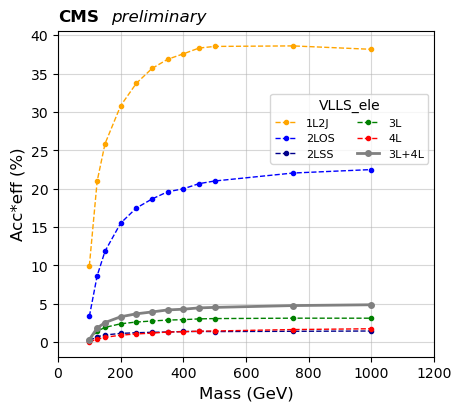

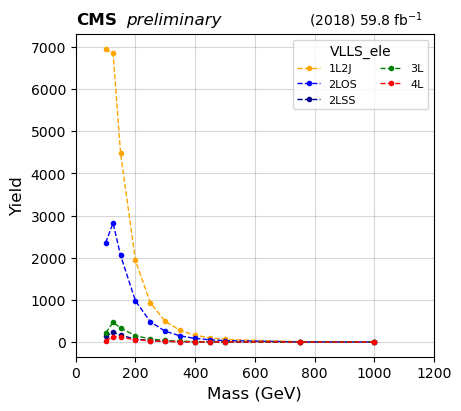

In [31]:
make_plot("VLLS_ele")

Yield (acceptance %) for VLLS_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	594746	3640 (5.2%)	6607 (9.4%)	7747 (11.1%)	2870 (4.1%)	191 (0.3%)	297 (0.4%)	45 (0.1%)	
125	599690	1660 (5.1%)	3591 (11.0%)	7236 (22.2%)	4450 (13.7%)	268 (0.8%)	535 (1.6%)	207 (0.6%)	
150	598660	765 (4.4%)	1863 (10.7%)	4566 (26.3%)	3022 (17.4%)	156 (0.9%)	365 (2.1%)	165 (1.0%)	
200	599555	204 (3.3%)	601 (9.6%)	1936 (30.8%)	1311 (20.9%)	63 (1.0%)	157 (2.5%)	75 (1.2%)	
250	496540	69 (2.5%)	226 (8.3%)	922 (33.5%)	625 (22.8%)	28 (1.0%)	76 (2.8%)	37 (1.4%)	
300	499438	26 (2.0%)	99 (7.3%)	483 (35.3%)	326 (23.8%)	14 (1.1%)	39 (2.9%)	20 (1.5%)	
400	198686	6 (1.5%)	26 (6.1%)	159 (36.9%)	108 (25.2%)	4 (1.0%)	13 (3.1%)	7 (1.7%)	
450	197673	3 (1.4%)	15 (5.9%)	98 (37.6%)	66 (25.4%)	2 (1.0%)	7 (3.1%)	4 (1.7%)	
500	199603	2 (1.2%)	9 (5.6%)	61 (37.7%)	42 (25.9%)	1 (1.0%)	5 (3.1%)	2 (1.8%)	
750	99672	0 (0.9%)	1 (6.0%)	8 (37.6%)	6 (27.0%)	0 (1.0%)	0 (3.2%)	0 (1.9%)	
1000	99496	0 (0.8%)	0 (6.9%)	1 (37.0%)	1 (27

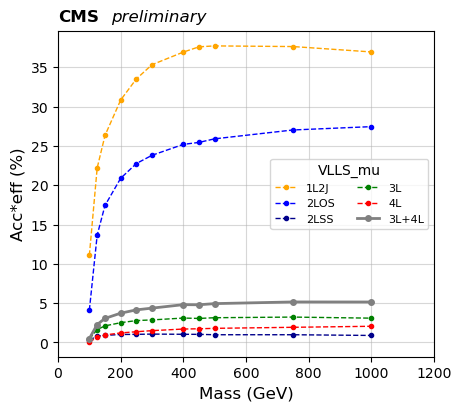

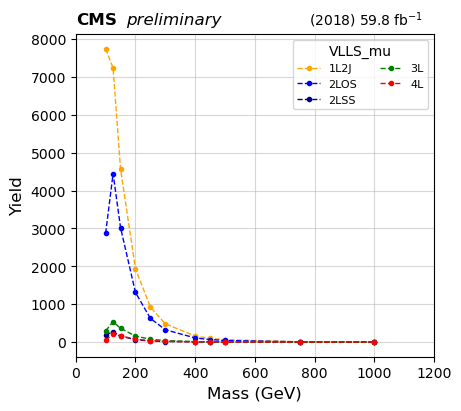

In [37]:
make_plot("VLLS_mu")

Yield (acceptance %) for VLLD_ele :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	110871	46187 (4.6%)	99757 (9.9%)	231136 (22.9%)	140411 (13.9%)	39879 (3.9%)	41465 (4.1%)	5195 (0.5%)	
200	73730	1200 (1.5%)	4060 (5.0%)	21365 (26.3%)	32181 (39.6%)	3826 (4.7%)	9041 (11.1%)	1922 (2.4%)	
300	24753	103 (0.6%)	497 (2.9%)	4263 (24.5%)	7858 (45.2%)	796 (4.6%)	2287 (13.1%)	532 (3.1%)	
400	24491	18 (0.3%)	95 (1.8%)	1261 (23.3%)	2601 (48.0%)	251 (4.6%)	744 (13.7%)	180 (3.3%)	
600	24611	3 (0.4%)	14 (1.7%)	211 (23.7%)	420 (47.2%)	42 (4.7%)	126 (14.2%)	27 (3.1%)	
800	23680	0 (0.1%)	2 (1.1%)	41 (19.9%)	104 (50.5%)	9 (4.8%)	32 (15.9%)	7 (3.6%)	
1000	24286	0 (0.1%)	0 (1.1%)	11 (19.3%)	29 (51.5%)	2 (4.7%)	9 (15.6%)	2 (4.0%)	

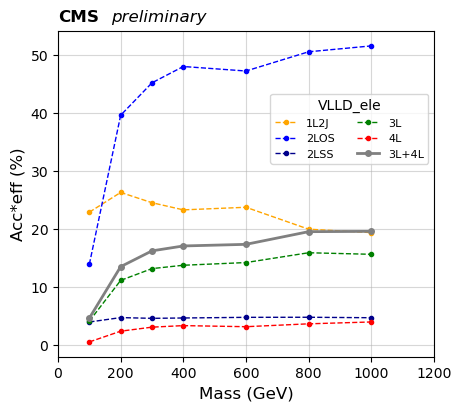

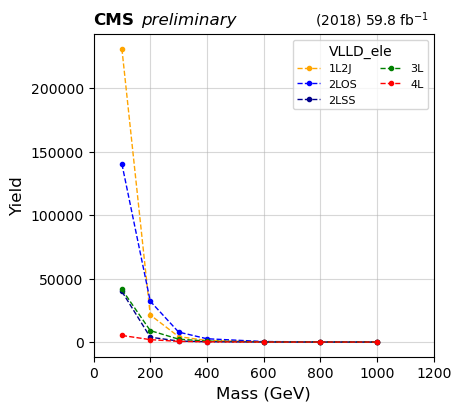

In [33]:
make_plot("VLLD_ele")

Yield (acceptance %) for VLLD_mu :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	111926	43738 (4.3%)	83476 (8.3%)	184009 (18.2%)	300551 (29.7%)	36740 (3.6%)	75440 (7.5%)	9814 (1.0%)	
200	73908	1065 (1.3%)	2791 (3.4%)	9635 (11.8%)	47027 (57.8%)	1783 (2.2%)	11631 (14.3%)	2651 (3.3%)	
300	25022	83 (0.5%)	315 (1.8%)	1915 (11.0%)	10574 (60.8%)	335 (1.9%)	2811 (16.2%)	665 (3.8%)	
400	24299	12 (0.2%)	53 (1.0%)	507 (9.4%)	3404 (62.8%)	93 (1.7%)	930 (17.2%)	219 (4.0%)	
600	24890	0 (0.1%)	5 (0.7%)	71 (8.0%)	570 (64.1%)	13 (1.5%)	162 (18.2%)	37 (4.2%)	
800	24763	0 (0.1%)	1 (0.6%)	15 (7.4%)	133 (64.5%)	3 (1.5%)	37 (18.2%)	9 (4.7%)	

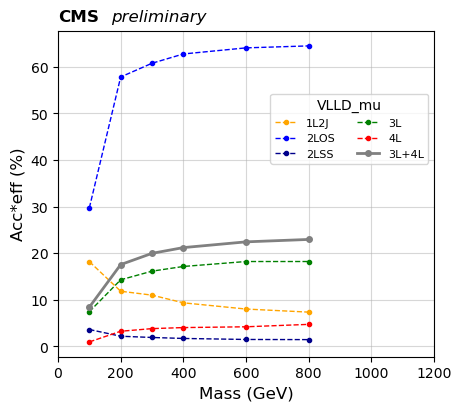

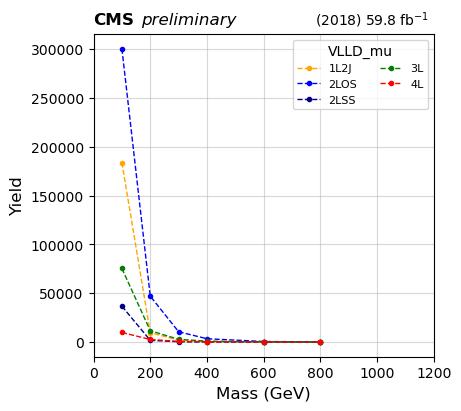

In [34]:
make_plot("VLLD_mu")

Yield (acceptance %) for VLLS_tau :
mass	nRAW	n1L0J		n1L1J		n1L2J		n2LOS		n2LSS		n3L		n4L

100	595015	3537 (11.6%)	6146 (20.1%)	5855 (19.2%)	2058 (6.7%)	82 (0.3%)	120 (0.4%)	4 (0.0%)	
125	610843	1306 (8.0%)	2577 (15.8%)	3709 (22.7%)	1361 (8.3%)	110 (0.7%)	175 (1.1%)	19 (0.1%)	
150	606340	568 (6.2%)	1325 (14.4%)	2537 (27.5%)	858 (9.3%)	81 (0.9%)	136 (1.5%)	17 (0.2%)	
200	605639	148 (4.2%)	431 (12.2%)	1199 (33.9%)	371 (10.5%)	38 (1.1%)	65 (1.9%)	9 (0.3%)	
250	492706	51 (3.2%)	170 (10.7%)	604 (37.7%)	179 (11.2%)	19 (1.2%)	33 (2.1%)	5 (0.3%)	
300	497882	20 (2.5%)	76 (9.5%)	324 (40.0%)	94 (11.7%)	10 (1.3%)	18 (2.2%)	3 (0.4%)	
350	197971	9 (2.2%)	38 (8.7%)	185 (41.5%)	53 (12.0%)	5 (1.3%)	10 (2.3%)	1 (0.4%)	
400	203000	4 (1.8%)	21 (8.1%)	112 (42.6%)	32 (12.3%)	3 (1.3%)	6 (2.4%)	1 (0.4%)	

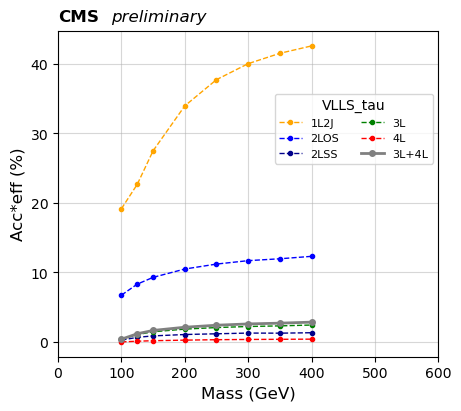

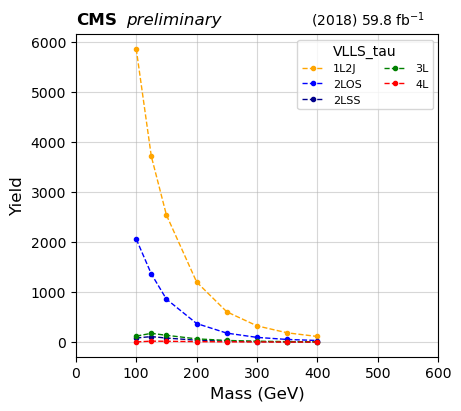

In [35]:
make_plot("VLLS_tau")